В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

In [1]:
# !pip install torch_geometric --quiet
# !pip install nni --quiet

Импортируем необходимые библиотеки

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split

from torch_geometric.utils import dense_to_sparse

from itertools import combinations

from multiprocessing import Pool, cpu_count

# Custom imports
from Graph import Graph
from GCN import (
    GCN,
    SimpleGCN,
    SimpleGAT,
    CustomDataset,
    train_model_accuracy,
    train_model_diversity,
    get_positive_and_negative
)

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [3]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [4]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [5]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [6]:
models_dict = load_json_from_directory('third_dataset')

Посмотрю как распределена точность моделей

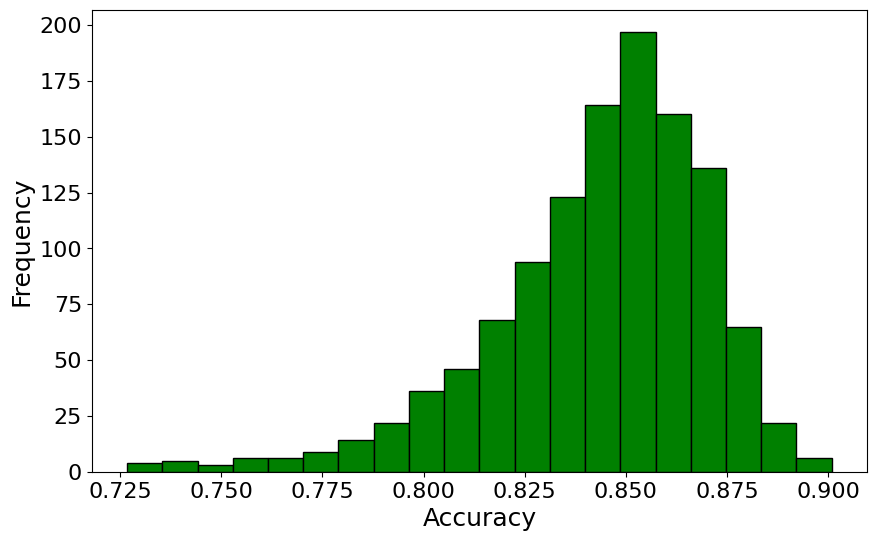

In [7]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green")
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [8]:
graph = Graph(models_dict[0])

Посмотрю как выглядит граф.

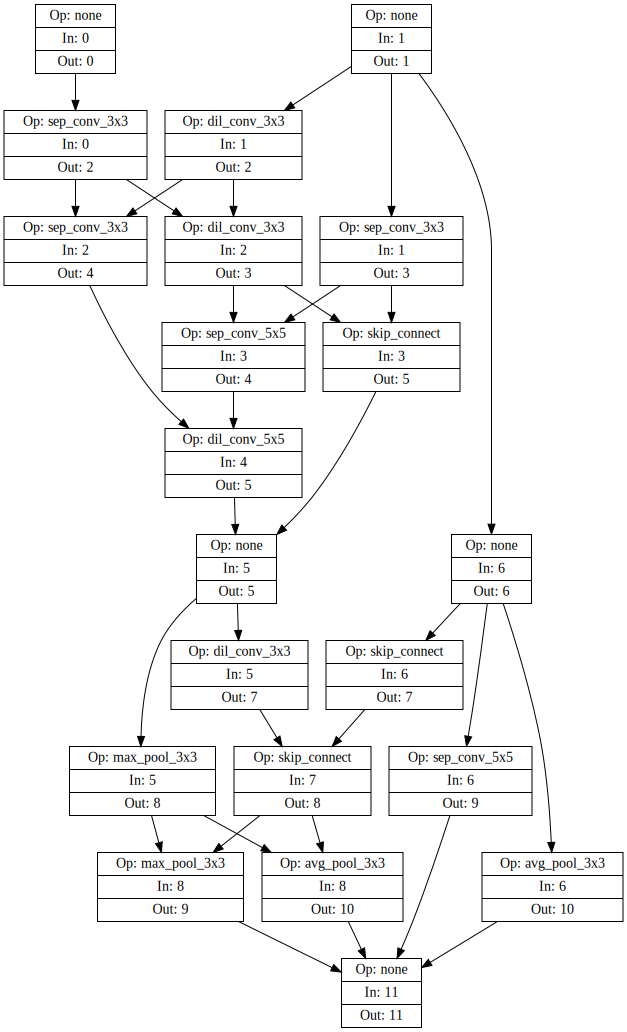

In [9]:
graph.show_graph()

In [10]:
graph.get_adjacency_matrix()

(array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [11]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: sep_conv_3x3 | In: 0 | Out: 2,
 Op: none | In: 1 | Out: 1,
 Op: dil_conv_3x3 | In: 1 | Out: 2,
 Op: sep_conv_3x3 | In: 1 | Out: 3,
 Op: dil_conv_3x3 | In: 2 | Out: 3,
 Op: sep_conv_3x3 | In: 2 | Out: 4,
 Op: sep_conv_5x5 | In: 3 | Out: 4,
 Op: skip_connect | In: 3 | Out: 5,
 Op: dil_conv_5x5 | In: 4 | Out: 5]

In [12]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: dil_conv_3x3 | In: 0 | Out: 2,
 Op: max_pool_3x3 | In: 0 | Out: 3,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: sep_conv_5x5 | In: 1 | Out: 4,
 Op: avg_pool_3x3 | In: 1 | Out: 5,
 Op: skip_connect | In: 2 | Out: 3,
 Op: max_pool_3x3 | In: 3 | Out: 4,
 Op: avg_pool_3x3 | In: 3 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [13]:
graph.get_adjacency_matrix()

(array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [14]:
def get_diversity(args):
    i, j, model_i, model_j = args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean(preds_i == preds_j)
    return (i, j, distance)

def get_diversity_using_jensen_shannon(args):
    i, j, model_i, model_j, num_samples = args
    indices = np.random.choice(len(model_i["test_predictions"]), num_samples, replace=False)
    preds_i = np.array(model_i["test_predictions"])[indices]
    preds_j = np.array(model_j["test_predictions"])[indices]
    distance = np.mean([jensenshannon(p1, p2) for p1, p2 in zip(preds_i, preds_j)])
    return (i, j, distance)

Построю матрицу разнообразия

In [ ]:
def get_diversity_matrix_naive(models_dict, num_samples=None):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    # Предобработка: обрезаем и кешируем предсказания
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        if num_samples is not None:
            preds = preds[:num_samples]
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(cached_preds[i] == cached_preds[j])
            diversity_matrix[i, j] = diversity_matrix[j, i] = distance

    return diversity_matrix

def get_diversity_matrix(models_dict, num_samples=2000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)
    
    # Кеширование предсказаний для каждой модели (ограничиваем до num_samples, если нужно)
    cached_preds = {
        i: np.array(models_dict[i]["test_predictions"])[:num_samples]
        for i in range(n_models)
    }
    
    # Список аргументов для всех пар (i,j)
    pairs = [
        (i, j, {"test_predictions": cached_preds[i]}, {"test_predictions": cached_preds[j]}, num_samples)
        for i, j in combinations(range(n_models), 2)
    ]
    
    with Pool(processes=cpu_count()) as pool:
        results = list(
            tqdm(
                pool.imap_unordered(get_diversity_using_jensen_shannon, pairs),
                total=len(pairs),
                desc="Расчет матрицы разнообразия",
            )
        )
    
    for i, j, dist in results:
        diversity_matrix[i, j] = dist
        diversity_matrix[j, i] = dist
    
    return diversity_matrix


In [16]:
diversity_matrix = get_diversity_matrix_naive(models_dict)

Computing diversity matrix: 100%|██████████| 1186/1186 [00:44<00:00, 26.88it/s] 


100%|██████████| 1186/1186 [00:00<00:00, 4645.68it/s]


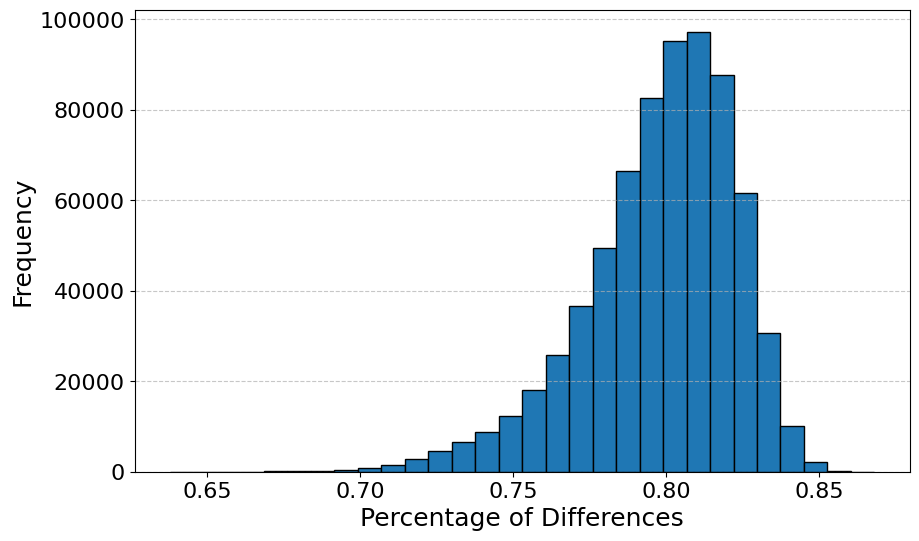

In [17]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=30, edgecolor="black")
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [18]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.90, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.1, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [19]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Строим тренировочный и валидационный датасеты.

In [21]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
accuracies = [model['test_accuracy'] for model in models_dict]
graphs_dataset = CustomDataset(graphs, accuracies)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

Train dataset size: 948
Test dataset size: 238


In [22]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [23]:
def extract_embeddings(model, dataset, device):
    model.to(device)
    model.eval()
    embeddings = []
    indices = []
    
    with torch.no_grad():
        for data in dataset:
            adj, features, index, _ = data
            
            # Перемещение данных на GPU (если используется)
            adj = adj.to(device)
            features = features.to(device)

            # Преобразование матрицы смежности в edge_index
            edge_index, _ = dense_to_sparse(adj)

            # Получение эмбеддинга графа
            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices

Обучим модель предсказывать точность по архитектуре.

In [24]:
input_dim = graphs_dataset[0][1].shape[1]
embedding_dim = 32
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 1
num_epochs = 15

model_accuracy = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=1e-4)
criterion = nn.MSELoss()

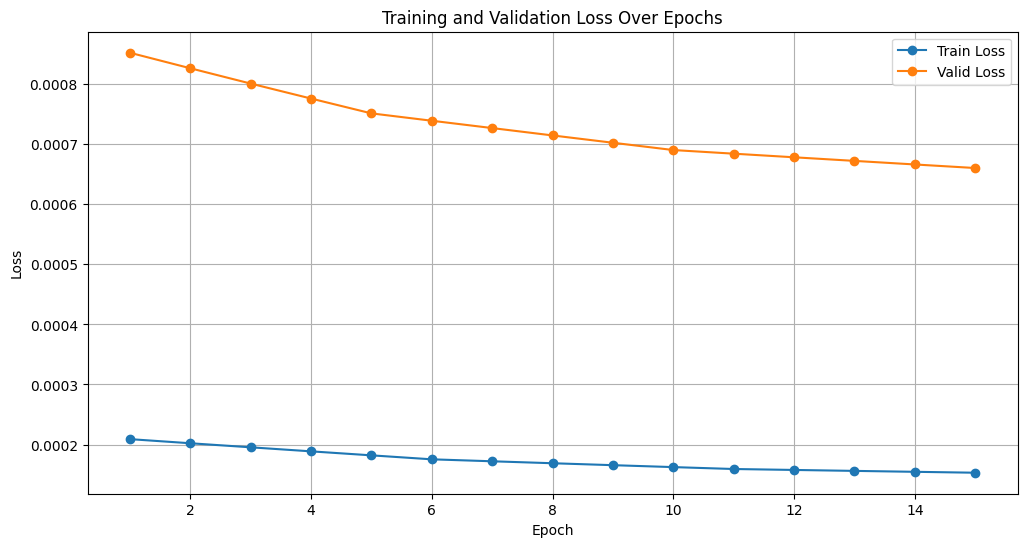

Training Progress: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]

Epoch 15, Train Loss: 0.0002, Valid Loss: 0.0007, LR: 0.000013


([0.0002090773910661287,
  0.0002022344729065392,
  0.00019548748490176622,
  0.0001887548950654042,
  0.00018210577059395706,
  0.00017548934065339937,
  0.00017221570643694592,
  0.00016896393668802478,
  0.00016573756807464085,
  0.00016253847110120557,
  0.00015936900354638885,
  0.0001577962865809348,
  0.00015623230911508392,
  0.0001547029124030584,
  0.00015318192510162224],
 [0.0008521176436368157,
  0.0008262908007918286,
  0.0008008012375911745,
  0.0007758860578056143,
  0.0007511923919204904,
  0.0007389396929941257,
  0.0007267424038478307,
  0.0007144803760432396,
  0.0007022997411359258,
  0.0006901531034157056,
  0.000684115566125437,
  0.0006781035736829293,
  0.0006721180652369972,
  0.0006661604182059024,
  0.000660229881270593])

In [ ]:
train_model_accuracy(
    model_accuracy,
    train_dataset,
    valid_dataset,
    optimizer,
    criterion,
    num_epochs,
    device="cpu",
    developer_mode=True
);

In [26]:
embeddings = extract_embeddings(model_accuracy, valid_dataset, device="cpu")[0]
for i, (adj, features, index, accuracy) in enumerate(valid_dataset):
    print(f"Index: {index:04d}, Accuracy: {accuracy.item():.3f}, Embedding: {embeddings[i][0]:.3f}")
    if i >= 20:
        break

Index: 0096, Accuracy: 0.849, Embedding: 0.453
Index: 0618, Accuracy: 0.840, Embedding: 0.489
Index: 0708, Accuracy: 0.836, Embedding: 0.491
Index: 0655, Accuracy: 0.835, Embedding: 0.470
Index: 0244, Accuracy: 0.805, Embedding: 0.528
Index: 0746, Accuracy: 0.851, Embedding: 0.474
Index: 0069, Accuracy: 0.853, Embedding: 0.494
Index: 0774, Accuracy: 0.802, Embedding: 0.470
Index: 0923, Accuracy: 0.850, Embedding: 0.488
Index: 0664, Accuracy: 0.863, Embedding: 0.498
Index: 0587, Accuracy: 0.848, Embedding: 0.527
Index: 0692, Accuracy: 0.870, Embedding: 0.491
Index: 0781, Accuracy: 0.824, Embedding: 0.489
Index: 0030, Accuracy: 0.862, Embedding: 0.489
Index: 0134, Accuracy: 0.868, Embedding: 0.446
Index: 0677, Accuracy: 0.853, Embedding: 0.496
Index: 1003, Accuracy: 0.835, Embedding: 0.487
Index: 0642, Accuracy: 0.850, Embedding: 0.494
Index: 0600, Accuracy: 0.852, Embedding: 0.487
Index: 0336, Accuracy: 0.845, Embedding: 0.494
Index: 1094, Accuracy: 0.843, Embedding: 0.492


In [27]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 16
num_epochs = 25

model = GCN(input_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

Основной код обучения модели похожести.

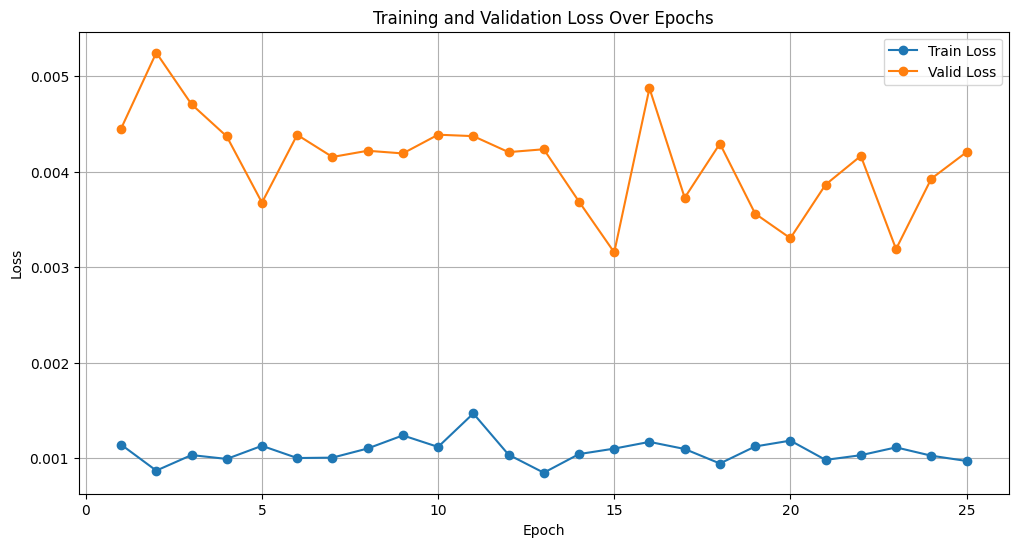

Training Progress: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]

Epoch 25, Train Loss: 0.0010, Valid Loss: 0.0042, LR: 0.000003


([0.0011419598563310969,
  0.0008692193131909591,
  0.0010320553045232589,
  0.0009915980860150816,
  0.0011289962233370367,
  0.0010011528111711332,
  0.0010050013975755072,
  0.0011009583996318061,
  0.0012382076510900183,
  0.0011173695451599636,
  0.0014680548559261274,
  0.0010359643129356803,
  0.0008471333402118602,
  0.0010423173632802842,
  0.0010997708336713445,
  0.0011702577273050945,
  0.0010958027236069306,
  0.0009437286401096778,
  0.0011221738807259732,
  0.001183552581046704,
  0.000981445491062438,
  0.0010307453226942552,
  0.001112606957994936,
  0.00102553576356751,
  0.0009702373028807499],
 [0.0044519114895027224,
  0.005247647020997119,
  0.0047077977356790495,
  0.004371190772337072,
  0.003677141265708859,
  0.004387267998286656,
  0.004155477054980623,
  0.0042204846854971235,
  0.004192500555214761,
  0.004388699010640634,
  0.004373725221938446,
  0.004206168551404937,
  0.004236170724660409,
  0.0036877301059851124,
  0.003155914925727524,
  0.00487569300

In [29]:
train_model_diversity(
    model,
    train_dataset,
    valid_dataset,
    discrete_diversity_matrix,
    optimizer,
    criterion,
    num_epochs,
    device="cpu",
    developer_mode=True,
);

In [36]:
def visualize_clusters(model, train_dataset, device="cpu", min_samples=3, xi=0.025, min_cluster_size=3):
  """
  Визуализирует кластеры, используя PCA для уменьшения размерности и OPTICS для кластеризации.

  Аргументы:
    model: Обученная модель для извлечения эмбеддингов.
    train_dataset: Датасет для обучения.
    device: Устройство для вычислений ("cpu" или "cuda").
    min_samples: Минимальное количество образцов для формирования кластера в OPTICS.
    xi: Параметр для определения устойчивости кластеров в OPTICS.
    min_cluster_size: Минимальный размер кластера в OPTICS.
  """
  # Извлечение эмбеддингов
  embeddings, indices = extract_embeddings(model, train_dataset, device=device)
  
  # Преобразование эмбеддингов в 2D с помощью PCA
  pca = PCA(n_components=2)
  embeddings_2d = pca.fit_transform(embeddings)

  # Кластеризация с помощью OPTICS
  optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size, metric="euclidean")
  clusters = optics.fit_predict(embeddings)

  # Визуализация кластеров
  plt.figure(figsize=(8, 6.5))
  scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=clusters, 
    cmap='tab10',  
    s=np.where(clusters == -1, 20, 70),  
    alpha=np.where(clusters == -1, 0.5, 1)
  )
  plt.xlabel("PCA Component 1", fontsize=16)
  plt.ylabel("PCA Component 2", fontsize=16)

  # Создание легенды для кластеров
  unique_clusters = np.unique(clusters)
  for cluster in unique_clusters:
    if cluster == -1:
      label = "Noise"
    else:
      label = f"Cluster {cluster}"
    plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label, s=50 if cluster != -1 else 20)

  plt.gca().set_facecolor('lightgrey')
  plt.show()

  return clusters

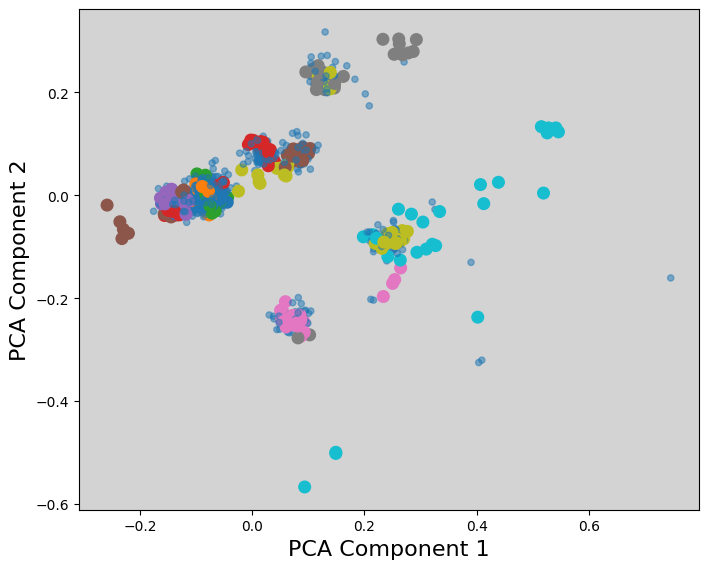

array([-1, -1, 58, -1, -1, 17, -1, 59,  6, -1, 65, 41, -1, -1, -1, -1, -1,
       59, -1, 10, -1, -1, -1, 11, -1, -1, -1, 14, -1, 30, -1,  0, -1, 53,
       55, 60, -1, -1, 39, 35, -1, -1, 22, 30, -1, 17, -1, -1, -1, 43, -1,
       -1, 27, -1, 46, -1, -1,  9, 50, -1, -1, 38, 11, -1, 22, -1, -1, -1,
       -1, -1, -1, 50, -1, -1, 28, -1, -1, 60, -1, -1, -1, 13, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, 47, 65, 10, -1, 21,  1, -1, -1, -1,  7, 10,
       -1, -1,  6, -1, -1, 51, -1, -1, 31, -1, -1, -1, -1, 20, -1, -1, -1,
       48, -1, -1, -1, -1, -1, -1, -1, 15, -1, 58, -1, 15, 23, -1, 13, -1,
       -1, 57, 29, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  3, 23, -1, 19, 64, 23, 29, 51, -1, 36, -1, -1,
       50, -1, 25, 40, 24, -1, 27, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       41, -1,  8, -1, -1, 29, -1, -1, -1, -1, -1, -1, 23, -1,  1, -1, 49,
       -1, -1, 38, -1, -1,  7, -1, 49, -1, 57, -1, -1, 19, -1, 25, -1, 49,
       33, 58, 30,  6,  5

In [ ]:
clusters = visualize_clusters(
    model,
    train_dataset,
    device="cpu",
    min_samples=3,
    xi=0.025,
    min_cluster_size=3
)

In [ ]:
# torch.save(model.state_dict(), "model_diversity_weights.pth")
# torch.save(model_accuracy.state_dict(), "model_accuracy_weights.pth")

In [ ]:
embeddings[0]

array([ 1.6673385 , -0.41023153,  2.1805983 , -0.9805621 ,  0.16340049,
        0.2892076 , -0.88501513, -0.81675166, -1.4027407 , -1.330269  ,
        0.7504825 , -0.17252213, -0.48153618, -0.7627205 , -0.04399444,
       -0.3247228 ], dtype=float32)

In [ ]:
def compute_correlation(models_dict, dataset, model, diversity_matrix, device="cpu"):
    model.to(device)
    model.eval()

    N = len(dataset)
    embeddings = []

    with torch.no_grad():
        for adj, features, index, _ in dataset:
            adj, features = adj.to(device), features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index).cpu().numpy()
            embeddings.append(embedding)

    embeddings = np.array(embeddings)

    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")

    architectures = [models_dict[index] for index in dataset.indices]

    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N), desc="Computing similarity matrix"):
        for j in range(i + 1, N):
            arch_i_index = dataset[i][2]
            arch_j_index = dataset[j][2]
            
            similarity_matrix[i, j] = diversity_matrix[arch_i_index, arch_j_index]
            similarity_matrix[j, i] = similarity_matrix[i, j]

    triu_indices = np.triu_indices(N, k=1)

    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation, _ = pearsonr(embedding_distances, similarity_values)

    return correlation

Рассчитаю корреляции

In [ ]:
pearson_correlation = compute_correlation(models_dict, valid_dataset, model, diversity_matrix, device="cuda")

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")

Computing similarity matrix: 100%|██████████| 238/238 [00:00<00:00, 1558.69it/s]

Корреляция Пирсона: -0.490


In [ ]:
min_samples = 10

for i in (range(len(set(clusters)) - 1)):
    cluster_indexes = np.where(clusters == i)[0]
    # print(cluster_indexes)
    
    positive_diversity = []
    negative_diversity = []
    
    for index in cluster_indexes:
        if index == cluster_indexes[0]:
            continue
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, cluster_indexes[0])
            if positive is None or negative is None:
                print(positive, negative)
                continue
            
            positive_diversity.append(get_diversity([index, positive, models_dict[index], models_dict[positive]])[-1])
            negative_diversity.append(get_diversity([index, negative, models_dict[index], models_dict[negative]])[-1])


    mean_positive_diversity = np.mean(positive_diversity) 
    mean_negative_diversity = np.mean(negative_diversity) 

    print(f"Cluster {i}:")
    print(f"  Mean Positive Diversity: {mean_positive_diversity:.4f}" if mean_positive_diversity is not None else "  No positive diversity data available.")
    print(f"  Mean Negative Diversity: {mean_negative_diversity:.4f}" if mean_negative_diversity is not None else "  No negative diversity data available.")
    if i >= 10:
        break

Cluster 0:
  Mean Positive Diversity: 0.8150
  Mean Negative Diversity: 0.7721
Cluster 1:
  Mean Positive Diversity: 0.8121
  Mean Negative Diversity: 0.7690
Cluster 2:
  Mean Positive Diversity: 0.8081
  Mean Negative Diversity: 0.7683
Cluster 3:
  Mean Positive Diversity: 0.8187
  Mean Negative Diversity: 0.7745
Cluster 4:
  Mean Positive Diversity: 0.8229
  Mean Negative Diversity: 0.7743
Cluster 5:
  Mean Positive Diversity: 0.8228
  Mean Negative Diversity: 0.7617
Cluster 6:
  Mean Positive Diversity: 0.8222
  Mean Negative Diversity: 0.7610
Cluster 7:
  Mean Positive Diversity: 0.7840
  Mean Negative Diversity: 0.7420
Cluster 8:
  Mean Positive Diversity: 0.8244
  Mean Negative Diversity: 0.7646
Cluster 9:
  Mean Positive Diversity: 0.8197
  Mean Negative Diversity: 0.7645
Cluster 10:
  Mean Positive Diversity: 0.8123
  Mean Negative Diversity: 0.7649


In [ ]:
cluster_1_indexes = np.where(clusters == 1)[0]
cluster_2_indexes = np.where(clusters == 2)[0]

similarities_within_cluster_1 = [
    get_diversity([i, j, models_dict[i], models_dict[j]])[-1]
    for i in cluster_1_indexes
    for j in cluster_1_indexes
    if i != j
]
mean_similarity_within_cluster_1 = np.mean(similarities_within_cluster_1)

similarities_between_clusters = [
    get_diversity([i, j, models_dict[i], models_dict[j]])[-1]
    for i in cluster_1_indexes
    for j in cluster_2_indexes
]
mean_similarity_between_clusters = np.mean(similarities_between_clusters)

print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")

Средняя похожесть внутри первого кластера: 0.7949
Средняя похожесть между первым и вторым кластерами: 0.7965


In [ ]:
with open("logs.txt", "w", encoding="utf-8") as log:
    for index in cluster_1_indexes:
        tmp_graph = Graph(models_dict[index], index=index)
        for key, value in models_dict[index]["architecture"].items():
            log.write(f"{key}: {value}\n")
        log.write("\n")  # Добавляем пустую строку между архитектурами